In [1]:
#
#  Copyright 2025 The InfiniFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#

import logging
import copy
import re
import sys
sys.path.append("../..")
# sys.path.append("/root/ragflow")
from api.db import ParserType
from rag.nlp import rag_tokenizer, tokenize, tokenize_table, add_positions, bullets_category, title_frequency, tokenize_chunks
from deepdoc.parser import PdfParser, PlainParser
import numpy as np


class Pdf(PdfParser):
    def __init__(self):
        self.model_speciess = ParserType.PAPER.value
        super().__init__()

    def __call__(self, filename, binary=None, from_page=0,
                 to_page=100000, zoomin=3, callback=None):
        from timeit import default_timer as timer
        start = timer()
        callback(msg="OCR started")
        self.__images__(
            filename if not binary else binary,
            zoomin,
            from_page,
            to_page,
            callback
        )
        callback(msg="OCR finished ({:.2f}s)".format(timer() - start))

        start = timer()
        self._layouts_rec(zoomin)
        callback(0.63, "Layout analysis ({:.2f}s)".format(timer() - start))
        logging.debug(f"layouts cost: {timer() - start}s")

        start = timer()
        self._table_transformer_job(zoomin)
        callback(0.68, "Table analysis ({:.2f}s)".format(timer() - start))

        start = timer()
        self._text_merge()
        tbls = self._extract_table_figure(True, zoomin, True, True)
        column_width = np.median([b["x1"] - b["x0"] for b in self.boxes])
        self._concat_downward()
        self._filter_forpages()
        callback(0.75, "Text merged ({:.2f}s)".format(timer() - start))

        # clean mess
        if column_width < self.page_images[0].size[0] / zoomin / 2:
            logging.debug("two_column................... {} {}".format(column_width,
                  self.page_images[0].size[0] / zoomin / 2))
            self.boxes = self.sort_X_by_page(self.boxes, column_width / 2)
        for b in self.boxes:
            b["text"] = re.sub(r"([\t 　]|\u3000){2,}", " ", b["text"].strip())

        def _begin(txt):
            return re.match(
                "[0-9. 一、i]*(introduction|abstract|摘要|引言|keywords|key words|关键词|background|背景|目录|前言|contents)",
                txt.lower().strip())

        if from_page > 0:
            return {
                "title": "",
                "authors": "",
                "abstract": "",
                "sections": [(b["text"] + self._line_tag(b, zoomin), b.get("layoutno", "")) for b in self.boxes if
                             re.match(r"(text|title)", b.get("layoutno", "text"))],
                "tables": tbls
            }
        # get title and authors
        title = ""
        authors = []
        i = 0
        while i < min(32, len(self.boxes)-1):
            b = self.boxes[i]
            i += 1
            if b.get("layoutno", "").find("title") >= 0:
                title = b["text"]
                if _begin(title):
                    title = ""
                    break
                for j in range(3):
                    if _begin(self.boxes[i + j]["text"]):
                        break
                    authors.append(self.boxes[i + j]["text"])
                    break
                break
        # get abstract
        abstr = ""
        i = 0
        while i + 1 < min(32, len(self.boxes)):
            b = self.boxes[i]
            i += 1
            txt = b["text"].lower().strip()
            if re.match("(abstract|摘要)", txt):
                if len(txt.split()) > 32 or len(txt) > 64:
                    abstr = txt + self._line_tag(b, zoomin)
                    break
                txt = self.boxes[i]["text"].lower().strip()
                if len(txt.split()) > 32 or len(txt) > 64:
                    abstr = txt + self._line_tag(self.boxes[i], zoomin)
                i += 1
                break
        if not abstr:
            i = 0

        callback(
            0.8, "Page {}~{}: Text merging finished".format(
                from_page, min(
                    to_page, self.total_page)))
        for b in self.boxes:
            logging.debug("{} {}".format(b["text"], b.get("layoutno")))
        logging.debug("{}".format(tbls))

        return {
            "title": title,
            "authors": " ".join(authors),
            "abstract": abstr,
            "sections": [(b["text"] + self._line_tag(b, zoomin), b.get("layoutno", "")) for b in self.boxes[i:] if
                         re.match(r"(text|title)", b.get("layoutno", "text"))],
            "tables": tbls
        }


def chunk(filename, binary=None, from_page=0, to_page=100000,
          lang="Chinese", callback=None, **kwargs):
    """
        Only pdf is supported.
        The abstract of the paper will be sliced as an entire chunk, and will not be sliced partly.
    """
    if re.search(r"\.pdf$", filename, re.IGNORECASE):
        if kwargs.get("parser_config", {}).get("layout_recognize", "DeepDOC") == "Plain Text":
            pdf_parser = PlainParser()
            paper = {
                "title": filename,
                "authors": " ",
                "abstract": "",
                "sections": pdf_parser(filename if not binary else binary, from_page=from_page, to_page=to_page)[0],
                "tables": []
            }
        else:
            pdf_parser = Pdf()
            paper = pdf_parser(filename if not binary else binary,
                               from_page=from_page, to_page=to_page, callback=callback)
    else:
        raise NotImplementedError("file type not supported yet(pdf supported)")

    doc = {"docnm_kwd": filename, "authors_tks": rag_tokenizer.tokenize(paper["authors"]),
           "title_tks": rag_tokenizer.tokenize(paper["title"] if paper["title"] else filename)}
    doc["title_sm_tks"] = rag_tokenizer.fine_grained_tokenize(doc["title_tks"])
    doc["authors_sm_tks"] = rag_tokenizer.fine_grained_tokenize(doc["authors_tks"])
    # is it English
    eng = lang.lower() == "english"  # pdf_parser.is_english
    logging.debug("It's English.....{}".format(eng))

    res = tokenize_table(paper["tables"], doc, eng)

    if paper["abstract"]:
        d = copy.deepcopy(doc)
        txt = pdf_parser.remove_tag(paper["abstract"])
        d["important_kwd"] = ["abstract", "总结", "概括", "summary", "summarize"]
        d["important_tks"] = " ".join(d["important_kwd"])
        d["image"], poss = pdf_parser.crop(
            paper["abstract"], need_position=True)
        add_positions(d, poss)
        tokenize(d, txt, eng)
        res.append(d)

    sorted_sections = paper["sections"]
    # set pivot using the most frequent type of title,
    # then merge between 2 pivot
    bull = bullets_category([txt for txt, _ in sorted_sections])
    most_level, levels = title_frequency(bull, sorted_sections)
    assert len(sorted_sections) == len(levels)
    sec_ids = []
    sid = 0
    for i, lvl in enumerate(levels):
        if lvl <= most_level and i > 0 and lvl != levels[i - 1]:
            sid += 1
        sec_ids.append(sid)
        logging.debug("{} {} {} {}".format(lvl, sorted_sections[i][0], most_level, sid))

    chunks = []
    last_sid = -2
    for (txt, _), sec_id in zip(sorted_sections, sec_ids):
        if sec_id == last_sid:
            if chunks:
                chunks[-1] += "\n" + txt
                continue
        chunks.append(txt)
        last_sid = sec_id
    res.extend(tokenize_chunks(chunks, doc, eng, pdf_parser))
    return res


"""
    readed = [0] * len(paper["lines"])
    # find colon firstly
    i = 0
    while i + 1 < len(paper["lines"]):
        txt = pdf_parser.remove_tag(paper["lines"][i][0])
        j = i
        if txt.strip("\n").strip()[-1] not in ":：":
            i += 1
            continue
        i += 1
        while i < len(paper["lines"]) and not paper["lines"][i][0]:
            i += 1
        if i >= len(paper["lines"]): break
        proj = [paper["lines"][i][0].strip()]
        i += 1
        while i < len(paper["lines"]) and paper["lines"][i][0].strip()[0] == proj[-1][0]:
            proj.append(paper["lines"][i])
            i += 1
        for k in range(j, i): readed[k] = True
        txt = txt[::-1]
        if eng:
            r = re.search(r"(.*?) ([\\.;?!]|$)", txt)
            txt = r.group(1)[::-1] if r else txt[::-1]
        else:
            r = re.search(r"(.*?) ([。？；！]|$)", txt)
            txt = r.group(1)[::-1] if r else txt[::-1]
        for p in proj:
            d = copy.deepcopy(doc)
            txt += "\n" + pdf_parser.remove_tag(p)
            d["image"], poss = pdf_parser.crop(p, need_position=True)
            add_positions(d, poss)
            tokenize(d, txt, eng)
            res.append(d)

    i = 0
    chunk = []
    tk_cnt = 0
    def add_chunk():
        nonlocal chunk, res, doc, pdf_parser, tk_cnt
        d = copy.deepcopy(doc)
        ck = "\n".join(chunk)
        tokenize(d, pdf_parser.remove_tag(ck), pdf_parser.is_english)
        d["image"], poss = pdf_parser.crop(ck, need_position=True)
        add_positions(d, poss)
        res.append(d)
        chunk = []
        tk_cnt = 0

    while i < len(paper["lines"]):
        if tk_cnt > 128:
            add_chunk()
        if readed[i]:
            i += 1
            continue
        readed[i] = True
        txt, layouts = paper["lines"][i]
        txt_ = pdf_parser.remove_tag(txt)
        i += 1
        cnt = num_tokens_from_string(txt_)
        if any([
            layouts.find("title") >= 0 and chunk,
            cnt + tk_cnt > 128 and tk_cnt > 32,
        ]):
            add_chunk()
            chunk = [txt]
            tk_cnt = cnt
        else:
            chunk.append(txt)
            tk_cnt += cnt

    if chunk: add_chunk()
    for i, d in enumerate(res):
        print(d)
        # d["image"].save(f"./logs/{i}.jpg")
    return res
"""


/root/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-15 15:35:41.311055205 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-07-15 15:35:41.311097628 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


'\n    readed = [0] * len(paper["lines"])\n    # find colon firstly\n    i = 0\n    while i + 1 < len(paper["lines"]):\n        txt = pdf_parser.remove_tag(paper["lines"][i][0])\n        j = i\n        if txt.strip("\n").strip()[-1] not in ":：":\n            i += 1\n            continue\n        i += 1\n        while i < len(paper["lines"]) and not paper["lines"][i][0]:\n            i += 1\n        if i >= len(paper["lines"]): break\n        proj = [paper["lines"][i][0].strip()]\n        i += 1\n        while i < len(paper["lines"]) and paper["lines"][i][0].strip()[0] == proj[-1][0]:\n            proj.append(paper["lines"][i])\n            i += 1\n        for k in range(j, i): readed[k] = True\n        txt = txt[::-1]\n        if eng:\n            r = re.search(r"(.*?) ([\\.;?!]|$)", txt)\n            txt = r.group(1)[::-1] if r else txt[::-1]\n        else:\n            r = re.search(r"(.*?) ([。？；！]|$)", txt)\n            txt = r.group(1)[::-1] if r else txt[::-1]\n        for p in pr

In [2]:
import sys
def dummy(prog=None, msg=""):
    print(prog,msg)
#chunk(sys.argv[1], callback=dummy)
import os
path = "/root/docs/"
files=os.listdir(path)
file_paths=[path+"/"+file for file in files]
print("file_paths=",file_paths)
for i in file_paths:
    print(i)
all_chunks = []
# 遍历处理每个文件
for i,path in enumerate(file_paths):
    print(f"第{i}path=",path)
    chunks = chunk(path, callback=dummy)

file_paths= ['/root/docs//rope旋转位置编码.pdf']
/root/docs//rope旋转位置编码.pdf
第0path= /root/docs//rope旋转位置编码.pdf
None OCR started
0.2571428571428571 
0.5142857142857142 
None OCR finished (107.45s)
0.63 Layout analysis (43.18s)


0.68 Table analysis (2.64s)
0.75 Text merged (5.11s)
0.8 Page 0~14: Text merging finished


In [3]:
chunks

[{'docnm_kwd': '/root/docs//rope旋转位置编码.pdf',
  'authors_tks': 'posit embed',
  'title_tks': 'roform enhanc transform with rotari',
  'title_sm_tks': 'roform enhanc transform with rotari',
  'authors_sm_tks': 'posit embed',
  'content_with_weight': '(1)\nqm =fg(cm,m)\nkn=fk(Cn,n)\nUn=f(Cn,n),',
  'content_ltks': '1 qm fg cm m kn fk cn n un f cn n',
  'content_sm_ltks': '1 qm fg cm m kn fk cn n un f cn n',
  'image': <PIL.Image.Image image mode=RGB size=823x121>,
  'doc_type_kwd': 'image',
  'page_num_int': [2],
  'position_int': [(2, 267, 542, 648, 689)],
  'top_int': [648]},
 {'docnm_kwd': '/root/docs//rope旋转位置编码.pdf',
  'authors_tks': 'posit embed',
  'title_tks': 'roform enhanc transform with rotari',
  'title_sm_tks': 'roform enhanc transform with rotari',
  'authors_sm_tks': 'posit embed',
  'content_with_weight': 'exp(nm)\n/d\nam,n\n√d\nN\n0m=\n_am,nUn\nn=1',
  'content_ltks': 'exp nm d am n d n 0m _ am nun n 1',
  'content_sm_ltks': 'exp nm d am n d n 0m _ am nun n 1',
  'image':

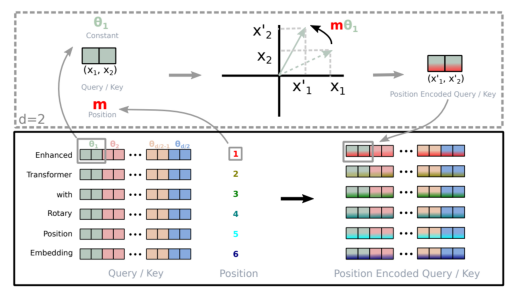

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

image = chunks[15]['image']  #Image.open("example.jpg")  # 替换为你的图片路径

plt.imshow(image)
plt.axis('off')  # 不显示坐标轴
plt.show()

In [21]:
chunks[15]

{'docnm_kwd': '/root/docs//rope旋转位置编码.pdf',
 'authors_tks': 'posit embed',
 'title_tks': 'roform enhanc transform with rotari',
 'title_sm_tks': 'roform enhanc transform with rotari',
 'authors_sm_tks': 'posit embed',
 'content_with_weight': "Figure 1: Implementation of Rotary Position Embedding(RoPE).\nm0\nx'2\nX2\n(X1,X2)\n(x'1,x'2)\nQuery / Key\nx'1\nX1\nm.\nd=2\n02\n..\nEnhanced\nTransforr\nrmer\nwith\n··\nRotary …·\n··\nPosition\nEmbedding\n：：\n6\nPosition\nPosition Er\ncodedQuery/Key\n/Key",
 'content_ltks': 'figur 1 implement of rotari posit embed rope m0 x 2 x2 x1 x2 x 1x 2 queri key x 1 x1 m d2 02 enhanc transforr rmer with rotari posit embed 6 posit posit er codedqueri key key',
 'content_sm_ltks': 'figur 1 implement of rotari posit embed rope m0 x 2 x2 x1 x2 x 1x 2 queri key x 1 x1 m d2 02 enhanc transforr rmer with rotari posit embed 6 posit posit er codedqueri key key',
 'image': <PIL.Image.Image image mode=RGB size=993x555>,
 'doc_type_kwd': 'image',
 'page_num_int': [5],